In [1]:
import warnings
warnings.filterwarnings("ignore")

import argparse
import logging
import os
import time

import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import torch
import yaml
from torch.utils.data import Dataset
import torchaudio

from tqdm import tqdm

import sys
sys.path.append("../")
import seq2seq_vc.models
from seq2seq_vc.utils import read_hdf5, write_hdf5
from seq2seq_vc.utils.plot import plot_attention, plot_generated_and_ref_2d, plot_1d
from seq2seq_vc.utils.types import str2bool
from seq2seq_vc.utils.duration_calculator import DurationCalculator

sys.path.append("../../cuhksz-phd/sho_util/pyfiles/")
from pytorch import cuda2numpy, cuda2cpu
from basic import plot_spectrogram
from sound import play_audio

sys.path.append("/mntcephfs/lab_data/shoinoue/Models/trained_models/vocos/vocos16k_noncausal_tealab/")
from vocos16k_inference import Vocos
from vocos.feature_extractors import MelSpectrogramFeatures, EncodecFeatures

def get_pretrained_model(config_path, model_path):
    if fs==24000:
        model = Vocos.from_hparams(config_path)
        state_dict = torch.load(model_path, map_location="cpu")
        if isinstance(model.feature_extractor, EncodecFeatures):
            encodec_parameters = {
                "feature_extractor.encodec." + key: value
                for key, value in model.feature_extractor.encodec.state_dict().items()
            }
            state_dict.update(encodec_parameters)
        model.load_state_dict(state_dict)
        model.eval();
    elif fs==16000:
        model = Vocos.from_hparams(config_path)
        state_dict_list = torch.load(model_path, map_location="cpu")
        state_dict = state_dict_list['state_dict']
        model_state_dict = model.state_dict()
        new_state_dict = {}
        for key, v in state_dict.items():
            if key in model_state_dict.keys():
                # print(key)
                new_state_dict[key] = v

        if isinstance(model.feature_extractor, EncodecFeatures):
            encodec_parameters = {
                "feature_extractor.encodec." + key: value
                for key, value in model.feature_extractor.encodec.state_dict().items()
            }
            state_dict.update(encodec_parameters)
        model.load_state_dict(new_state_dict, strict=True)
        model.eval();
    return model


class Dict2Obj(object):
    def __init__(self, dictionary):
        """Constructor"""
        for key in dictionary:
            setattr(self, key, dictionary[key])

import joblib
import glob
datasplit = list(np.load("./data_split_ARCTIC.npy", allow_pickle=True))

class ParallelVCMelDataset(Dataset):
    def __init__(self, dataset_dir, speakers, src_spk, trg_spk, datasplit, scaler, mode="train"):
        modefiles = datasplit[["train", "valid", "test"].index(mode)]
        filenames = [os.path.basename(a)[:-4] for a in glob.glob(dataset_dir+f"{speakers[0]}/mel/*")]
        filenames.sort()
        files = []
        for fn in filenames:
            if fn in modefiles:
                exist = True
                for spk in speakers[1:]:
                    if not(os.path.exists(dataset_dir + f"{spk}/mel/{fn}.npy")):
                        exist = False
                        break
                if exist:
                    files += [fn]
        data = {}
        for spk in speakers:
            data[spk] = [dataset_dir + f"{spk}/mel/{fn}.npy" for fn in files]
            
        self.data = data
        self.src_spk = src_spk
        self.trg_spk = trg_spk
        self.scaler = scaler
        self.files = files
        
    def __len__(self):
        return len(self.data[self.src_spk])
    def __getitem__(self, idx):
        items = {}
        items["src_feat"] = self.scaler.transform(np.load(self.data[self.src_spk][idx]).T)
        items["trg_feat"] = self.scaler.transform(np.load(self.data[self.trg_spk][idx]).T)
        items["utt_id"] = self.files[idx]
        
        return items

################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



In [2]:
# Dataset Variables
dataset_dir = "/mntcephfs/lab_data/shoinoue/Dataset/L2-ARCTIC/"
speakers = ["HKK", "TNI"]
src_spk = "HKK"
trg_spk = "TNI"

scaler_filename = f"ckpts/scalers/HKK_TNI.save"
scaler = joblib.load(scaler_filename)

In [3]:
args = {}
args["rank"] = 0
args["checkpoint"] = "/mntcephfs/lab_data/shoinoue/Models/trained_models/AC_01/ckpts/HKK_TNI/checkpoint-50000steps.pkl"
args["outdir"] = "./ckpts/outputs/HKK_INI/"
args["config_path"] = "./../egs/arctic/vc1/conf/vtn.v1.melmel.yaml"
args["init_checkpoint"] = ""
args["resume"] = ""
args["distributed"] = False
args = Dict2Obj(args)

# load main config
with open(args.config_path) as f:
    config = yaml.load(f, Loader=yaml.Loader)
config.update(vars(args))

# Customization
config["model_params"]["idim"] = 100
config["model_params"]["odim"] = 100

In [4]:
device = torch.device("cuda")
torch.backends.cudnn.benchmark = True
torch.cuda.set_device(args.rank)
    
### Dataset Preparation ###
dataset = ParallelVCMelDataset(dataset_dir, speakers, src_spk, trg_spk, datasplit, scaler, "test")

### Model Preparation ###
model_class = getattr(seq2seq_vc.models, config["model_type"])
model = model_class(**config["model_params"])
model.load_state_dict(torch.load(args.checkpoint, map_location="cpu")["model"])
model = model.eval().to(device)
    
### Vocoder Preparation ###
data_dir = "/mntcephfs/lab_data/shoinoue/"
fs = 24000
# fs = 16000

if fs==24000:
    config_path = f"{data_dir}Models/trained_models/vocos/24k/config.yaml"
    model_path = f"{data_dir}Models/trained_models/vocos/24k/pytorch_model.bin"
elif fs==16000:
    config_path = f"{data_dir}Models/trained_models/vocos/vocos16k_noncausal_tealab/config16k.yaml"
    model_path = f"{data_dir}Models/trained_models/vocos/vocos16k_noncausal_tealab/vocos16k_noncausal_last.ckpt"
vocoder = get_pretrained_model(config_path, model_path)

In [5]:
with torch.no_grad(), tqdm(dataset, desc="[decode]") as pbar:
    for idx, batch in enumerate(pbar, 1):
        start_time = time.time()
        utt_id = batch["utt_id"]
        x = batch["src_feat"]
        x = torch.tensor(x, dtype=torch.float).to(device)
        outs, probs, att_ws = model.inference(
            x, config["inference"], spemb=None
        )

        # plot figures
        plot_generated_and_ref_2d(
            outs.cpu().numpy(),
            config["outdir"] + f"/outs/{utt_id}.png",
            origin="lower",
        )
        
        plot_1d(
            probs.cpu().numpy(),
            config["outdir"] + f"/probs/{utt_id}_prob.png",
        )
        plot_attention(
            att_ws.cpu().numpy(),
            config["outdir"] + f"/att_ws/{utt_id}_att_ws.png",
        )
        
        ### Waveform ###
        if not os.path.exists(os.path.join(config["outdir"], "wav")):
            os.makedirs(os.path.join(config["outdir"], "wav"), exist_ok=True)
        denormalized_mel = scaler.inverse_transform(cuda2numpy(outs))
        y = vocoder.decode(torch.tensor(denormalized_mel.T).unsqueeze(0))
        sf.write(
            os.path.join(config["outdir"], "wav", f"{utt_id}.wav"),
            y.cpu().numpy()[0],
            fs,
            "PCM_16",
        )
        
        ### Mel ###
        if not os.path.exists(os.path.join(config["outdir"], "mel")):
            os.makedirs(os.path.join(config["outdir"], "mel"), exist_ok=True)
            
        np.save(os.path.join(config["outdir"], "mel", f"{utt_id}.npy"), denormalized_mel)
        if idx>10:
            break

[decode]:  10%|█         | 10/100 [00:44<06:36,  4.40s/it]


# Check the result

source


ground truth


predicted


<AxesSubplot: >

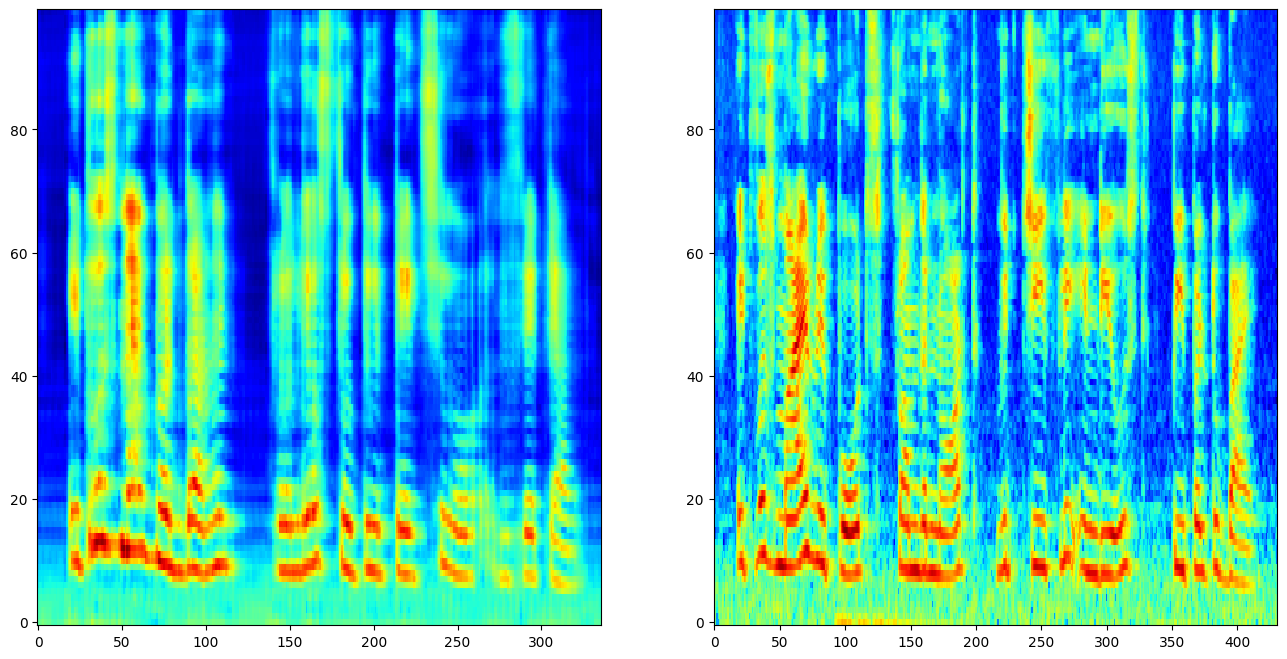

In [7]:
utt_id = dataset.files[0]
data = dataset[dataset.files.index(utt_id)]

melpath = os.path.join(config["outdir"], "mel", f"{utt_id}.npy")
wavpath = os.path.join(config["outdir"], "wav", f"{utt_id}.wav")
predmel = np.load(melpath)
predwav, sr = torchaudio.load(wavpath)
gtmel = data["trg_feat"]
gtmel = scaler.inverse_transform(gtmel)
gtwav = vocoder.decode(torch.tensor(gtmel.T).unsqueeze(0))
sourcemel = data["src_feat"]
sourcemel = scaler.inverse_transform(sourcemel)
sourcewav = vocoder.decode(torch.tensor(sourcemel.T).unsqueeze(0))

%matplotlib inline  
fig = plt.figure(figsize=(16, 8))
print("source")
play_audio(sourcewav, fs)
print("ground truth")
play_audio(gtwav, fs)
print("predicted")
play_audio(predwav, sr)
plot_spectrogram(predmel.T, fig, (1,2,1))
plot_spectrogram(gtmel.T, fig, (1,2,2))